## BERT model for MITMovies Dataset
I was going to make this repository a package with setup.py and everything but because of my deadlines and responsibilities at my current workplace I haven't got the time to do that so I shared the structure of the project in README.md file.

In [1]:
# If any issues open the one that gives error
# !pip install transformers
# !pip install torch==1.5.1
# !pip install tqdm
# !pip install tensorboard
# !pip install seqeval
# ! pip install tqdm
# ! pip install seaborn
# !pip install gensim

In [1]:
import os
import sys
import json
import numpy as np
from tqdm import tqdm
sys.path.append("..")

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import tensorboard
from seqeval.metrics import classification_report
from transformers import Trainer, TrainingArguments
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from transformers import (WEIGHTS_NAME, AdamW, BertConfig,
                                  BertForTokenClassification, BertTokenizerFast,
                                  get_linear_schedule_with_warmup)
from src.namedentityrecognizer.models.bertner import BertNerModel
from src.namedentityrecognizer.data.analyze_dataset import Analyzer
from src.namedentityrecognizer.data.build_dataset import BuildData
from src.namedentityrecognizer.data.make_dataset import MakeData
from src.namedentityrecognizer.utils.processors import NerPreProcessor, NerDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [3]:
# Some initializers
train = True
num_train_epochs = 5
train_batch_size = 32
eval_batch_size = 8
# Weight decay for regularization
weight_decay = 0.01
# Now 1 but if batches wont fit RAM can be increased
gradient_accumulation_steps = 1
# %10 warm up
warmup_proportion = 0.1
# Adam variables
adam_epsilon = 1e-8
learning_rate = 5e-5
# 16 floating point instead of 32
fp16 = False
if fp16:
    # Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']
    fp16_opt_level
# max seq length (for engtrain.bio since the lengths are pretty short 128 is alright)
max_seq_length = 128
# For gradient clipping
max_grad_norm = 1.0
# For having flexibility over hardware
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Data path
data_dir = "/content/drive/MyDrive/MovieEntityRecognizer/data/modified"
# Tensorboard Name
tensorboard_writer = tensorboard.SummaryWriter("bert_base_uncased_default")

validate = True
test = True

In [4]:
# For downloading data, doesn't require ssl so if downloaded no need to run it again
# dataset_names = ["engtrain.bio", "engtest.bio", "trivia10k13train.n,bio", "trivia10k13test.bio"]
# (MakeData.download_data(os.path.join("http://groups.csail.mit.edu/sls/downloads/movie", dataset_name) for dataset_name in dataset_names)



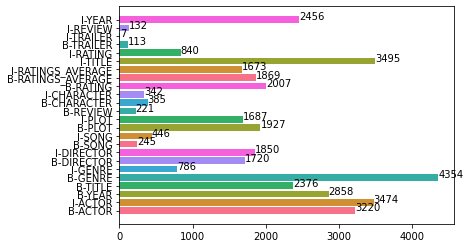

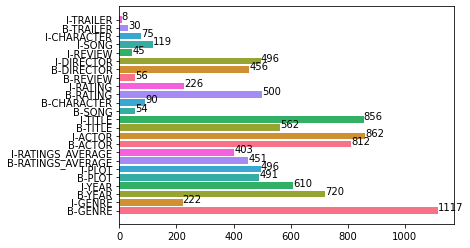

In [5]:
# Count also word frequencies and lengths or sentences
train_labels = Analyzer.count_labels("/home/karaz/Desktop/MovieEntityRecognizer/data/raw/mitmovies/engtrain.bio", without_o=True)
Analyzer.plot_data(train_labels)
test_labels = Analyzer.count_labels("/home/karaz/Desktop/MovieEntityRecognizer/data/raw/mitmovies/engtest.bio", without_o=True)
Analyzer.plot_data(test_labels)

In [6]:
# Get distinct labels
label_list = sorted(list(train_labels.keys()))
label_list.append("O")
num_labels = len(label_list)
label_map = {label: id for id, label in enumerate(label_list)}
print(f"Size of labels of regular dataset: {len(label_list)}\n{label_map}")

Size of labels of regular dataset: 25
{'B-ACTOR': 0, 'B-CHARACTER': 1, 'B-DIRECTOR': 2, 'B-GENRE': 3, 'B-PLOT': 4, 'B-RATING': 5, 'B-RATINGS_AVERAGE': 6, 'B-REVIEW': 7, 'B-SONG': 8, 'B-TITLE': 9, 'B-TRAILER': 10, 'B-YEAR': 11, 'I-ACTOR': 12, 'I-CHARACTER': 13, 'I-DIRECTOR': 14, 'I-GENRE': 15, 'I-PLOT': 16, 'I-RATING': 17, 'I-RATINGS_AVERAGE': 18, 'I-REVIEW': 19, 'I-SONG': 20, 'I-TITLE': 21, 'I-TRAILER': 22, 'I-YEAR': 23, 'O': 24}


In [7]:
# model configurations and tokenizer
config = BertConfig.from_pretrained("bert-large-uncased", num_labels=num_labels, finetuning_task="ner")
tokenizer = BertTokenizerFast.from_pretrained("bert-large-uncased")

In [10]:
# Change home karaz desktop path to your home directory (basically where the repository is)
dataset = BuildData.create_dataset("/home/karaz/Desktop/MovieEntityRecognizer/data/modified/mitmovies")
id2label = {id: label for (label,id) in label_map.items()}
id2label[-100] = 'X'
id2label

{0: 'B-ACTOR',
 1: 'B-CHARACTER',
 2: 'B-DIRECTOR',
 3: 'B-GENRE',
 4: 'B-PLOT',
 5: 'B-RATING',
 6: 'B-RATINGS_AVERAGE',
 7: 'B-REVIEW',
 8: 'B-SONG',
 9: 'B-TITLE',
 10: 'B-TRAILER',
 11: 'B-YEAR',
 12: 'I-ACTOR',
 13: 'I-CHARACTER',
 14: 'I-DIRECTOR',
 15: 'I-GENRE',
 16: 'I-PLOT',
 17: 'I-RATING',
 18: 'I-RATINGS_AVERAGE',
 19: 'I-REVIEW',
 20: 'I-SONG',
 21: 'I-TITLE',
 22: 'I-TRAILER',
 23: 'I-YEAR',
 24: 'O',
 -100: 'X'}

In [11]:
if train:
    num_train_optimization_steps = int(
    len(dataset['train_instances']) / train_batch_size / gradient_accumulation_steps) * num_train_epochs
    print(f"Number of training steps {num_train_optimization_steps}")
    print(f"Number of training instances {len(dataset['train_instances'])}")

if test:
    test_steps = int(
    len(dataset['test_instances']) / eval_batch_size)
    print(f"Number of test steps {test_steps}")
    print(f"Number of test instances {len(dataset['test_instances'])}")

Number of training steps 1525
Number of training instances 9775
Number of test steps 305
Number of test instances 2443


In [12]:
# Tokenize the datasets
train_tokens = tokenizer(dataset["train_instances"], is_split_into_words=True, return_offsets_mapping=True,
                            padding=True, truncation=True)

test_tokens = tokenizer(dataset['test_instances'], is_split_into_words=True, return_offsets_mapping=True, 
                            padding=True, truncation=True)

In [13]:
# Encode labels and give -100 to tokens which you dont want to backpropagate (basically mask them out)
train_labels = NerPreProcessor.convert_labels(dataset["train_labels"], 
                                        label_map, 
                                        train_tokens)

test_labels = NerPreProcessor.convert_labels(dataset['test_labels'],
                                      label_map, 
                                      test_tokens)

In [14]:
# Get rid of unnecessary data and create final data
if train_tokens["offset_mapping"]:
    train_tokens.pop("offset_mapping") 
if test_tokens["offset_mapping"]:
    test_tokens.pop("offset_mapping")

train_dataset = NerDataset(train_tokens, train_labels)
test_dataset = NerDataset(test_tokens, test_labels)

In [15]:
# Model initialization for high level api of huggingface
def model_init():
    model = BertForTokenClassification.from_pretrained('bert-large-uncased', num_labels=len(label_map))
    return model

In [16]:
# I left the compute metrics here in order to show how the evaluation
def compute_metrics(p):

        predictions, labels = p
        predictions = np.argmax(predictions, axis=2)

        # Remove ignored index (special tokens)
        true_predictions = [
            [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]

        preds_stretched = [label for doc in true_predictions for label in doc]
        trues_stretched = [label for doc in true_labels for label in doc]

        return {
            "accuracy_score": accuracy_score(trues_stretched, preds_stretched),
            "precision": precision_score(trues_stretched, preds_stretched, labels=np.unique(preds_stretched), average='macro'),
            "recall": recall_score(trues_stretched, preds_stretched, labels=np.unique(preds_stretched), average='macro'),
            "f1_macro": f1_score(trues_stretched, preds_stretched, labels=np.unique(preds_stretched), average='macro'),
            "f1_micro": f1_score(trues_stretched, preds_stretched, average='micro'),
        }

In [18]:
model_name = "bert-large-uncased-micro-10epoch"
training_args = TrainingArguments(
    output_dir =  "/home/kemalaraz/Desktop/MovieEntityRecognizer/pretrained_models/" +  model_name,          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs = 10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir = "/home/kemalaraz/Desktop/MovieEntityRecognizer/pretrained_models/" + model_name + '/logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end=True,
    learning_rate = 5e-5,
    seed = 42
)
# The high level api of the trainer
trainer = Trainer(                        
    model_init = model_init,
    args = training_args,                  
    train_dataset = train_dataset,         
    eval_dataset = test_dataset,
    compute_metrics = compute_metrics 
)

KeyboardInterrupt: 

In [ ]:
training_results = trainer.train()
evaluate_results_with_best_epoch = trainer.evaluate()

In [27]:
# For basic inference
model = BertForTokenClassification.from_pretrained(path_to_the_model, num_labels=len(label_map))

In [26]:
tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode("list the five star movies starring john lennon")))
inputs = tokenizer.encode("list the four star movies starring john lennon", return_tensors="pt")

outputs = model(inputs)[0]
predictions = torch.argmax(outputs, dim=2)

print([(token, label_list[prediction]) for token, prediction in zip(tokens, predictions[0].tolist())])

[('[CLS]', 'O'), ('list', 'O'), ('the', 'O'), ('five', 'B-RATINGS_AVERAGE'), ('star', 'O'), ('movies', 'O'), ('starring', 'O'), ('john', 'B-ACTOR'), ('lennon', 'I-ACTOR'), ('[SEP]', 'O')]


## Attachments 

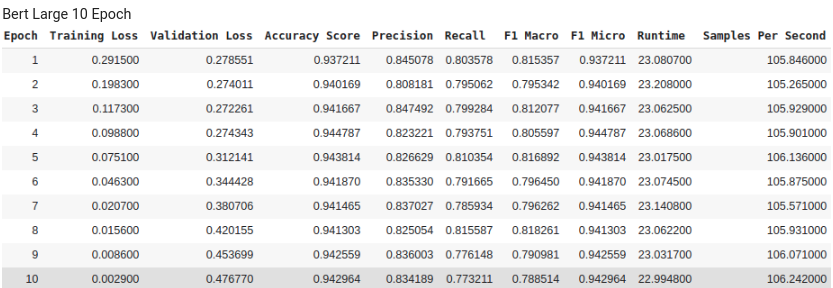

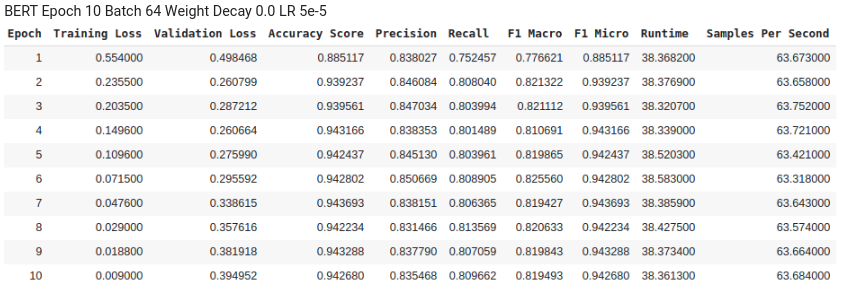

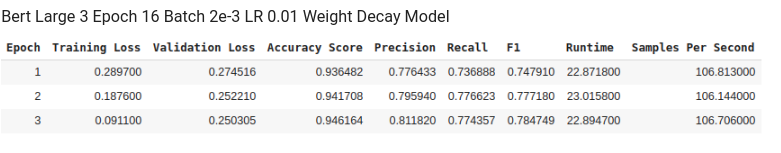

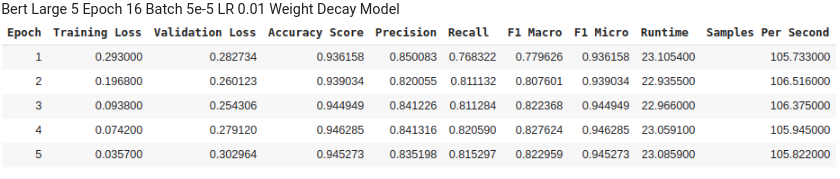

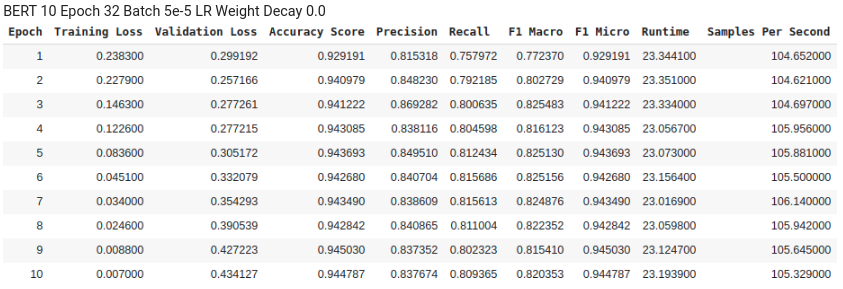